In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
sys.path.append('/content/drive/My Drive/big_data/')

In [ ]:
import pyspark.sql.types as types
schema = (types.StructType()
              .add('author id', types.StringType(), True)
              .add('created_at', types.StringType(), True)
              .add('geo', types.StringType(), True)
              .add('bbox', types.StringType(), True)
              .add('like_count', types.FloatType(), True)
              .add('tweet', types.StringType(), True)
              )

df = ( spark.read.format("csv")
          .schema(schema)
          .option("mode", "PERMISSIVE")
          .option("columnNameOfCorruptRecord", "corrupted_records")
          .load(r'/content/drive/My Drive/big_data/data/data.csv')
      )

df.show(20,truncate=False)

+------------------------------------------------------+-------------------------------------------------------+--------------------+------------------------------------------------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|author id                                             |created_at                                             |geo                 |bbox                                            |like_count|tweet                                                                                                                                                                                                                                                                                                           

In [ ]:

print((df.count(), len(df.columns)))

# Drop null values
df=df.na.drop("any")
print((df.count(), len(df.columns)))


(979407, 6)
(730537, 6)


In [ ]:
'''
from pyspark.sql import SparkSession, Row

df2=df.take(10000)
spark = SparkSession.builder.getOrCreate()
df = spark.createDataFrame(df2)
print((df.count(), len(df.columns)))
'''

'\nfrom pyspark.sql import SparkSession, Row\n\ndf2=df.take(10000)\nspark = SparkSession.builder.getOrCreate()\ndf = spark.createDataFrame(df2)\nprint((df.count(), len(df.columns)))\n'

In [ ]:
pd_df= pd.read_csv(r'/content/drive/My Drive/big_data/data/data.csv')  
pd_df.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(730531, 6)

## Text Preprocessing

### Remove non ASCII characters

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import string
import re

# remove non ASCII characters
def strip_non_ascii(data_str):
    stripped = (c for c in data_str if 0 < ord(c) < 127)
    return ''.join(stripped)

# setup pyspark udf function
strip_non_ascii_udf = udf(strip_non_ascii, StringType())
df = df.withColumn('tweet',strip_non_ascii_udf(df['tweet']))

df.show(5,True)

+------------+--------------------+-------------+--------------------+----------+--------------------+
|   author id|          created_at|          geo|                bbox|like_count|               tweet|
+------------+--------------------+-------------+--------------------+----------+--------------------+
|  23083547.0|2022-01-09 23:59:...|Virginia, USA|[-83.67529, 36.54...|       3.0|Im fascinated by ...|
| 320187191.0|2022-01-09 23:59:...|    Ohio, USA|[-84.8203089, 38....|       1.0|@Andygz10 @FoxNew...|
|    1.11e+18|2022-01-09 23:59:...|  Atlanta, GA|[-84.576827, 33.6...|       1.0|@jolievie123 This...|
| 188675285.0|2022-01-09 23:58:...| Portales, NM|[-103.365502, 34....|       0.0|The More You Know!!!|
|1201443878.0|2022-01-09 23:58:...| Pearland, TX|[-95.438435, 29.4...|       0.0|@GOP Because the ...|
+------------+--------------------+-------------+--------------------+----------+--------------------+
only showing top 5 rows



### Fixed abbreviation

In [ ]:
# fix abbreviation
def fix_abbreviation(data_str):
    data_str = data_str.lower()
    data_str = re.sub(r'\bthats\b', 'that is', data_str)
    data_str = re.sub(r'\bive\b', 'i have', data_str)
    data_str = re.sub(r'\bim\b', 'i am', data_str)
    data_str = re.sub(r'\bya\b', 'yeah', data_str)
    data_str = re.sub(r'\bcant\b', 'can not', data_str)
    data_str = re.sub(r'\bdont\b', 'do not', data_str)
    data_str = re.sub(r'\bwont\b', 'will not', data_str)
    data_str = re.sub(r'\bid\b', 'i would', data_str)
    data_str = re.sub(r'wtf', 'what the fuck', data_str)
    data_str = re.sub(r'\bwth\b', 'what the hell', data_str)
    data_str = re.sub(r'\br\b', 'are', data_str)
    data_str = re.sub(r'\bu\b', 'you', data_str)
    data_str = re.sub(r'\bk\b', 'OK', data_str)
    data_str = re.sub(r'\bsux\b', 'sucks', data_str)
    data_str = re.sub(r'\bno+\b', 'no', data_str)
    data_str = re.sub(r'\bcoo+\b', 'cool', data_str)
    data_str = re.sub(r'rt\b', '', data_str)
    data_str = data_str.strip()
    return data_str

fix_abbreviation_udf = udf(fix_abbreviation, StringType())
df = df.withColumn('tweet',fix_abbreviation_udf(df['tweet']))
df.show(5,True)

+------------+--------------------+-------------+--------------------+----------+--------------------+
|   author id|          created_at|          geo|                bbox|like_count|               tweet|
+------------+--------------------+-------------+--------------------+----------+--------------------+
|  23083547.0|2022-01-09 23:59:...|Virginia, USA|[-83.67529, 36.54...|       3.0|i am fascinated b...|
| 320187191.0|2022-01-09 23:59:...|    Ohio, USA|[-84.8203089, 38....|       1.0|@andygz10 @foxnew...|
|    1.11e+18|2022-01-09 23:59:...|  Atlanta, GA|[-84.576827, 33.6...|       1.0|@jolievie123 this...|
| 188675285.0|2022-01-09 23:58:...| Portales, NM|[-103.365502, 34....|       0.0|the more you know!!!|
|1201443878.0|2022-01-09 23:58:...| Pearland, TX|[-95.438435, 29.4...|       0.0|@gop because the ...|
+------------+--------------------+-------------+--------------------+----------+--------------------+
only showing top 5 rows



### Remove irrelevant features

In [ ]:
def remove_features(data_str):
    # Compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # Convert to lowercase
    data_str = data_str.lower()
    # Remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    # Remove @mentions
    data_str = mention_re.sub(' ', data_str)
    # Remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # Remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # Remove non a-z 0-9 characters and words shorter than 1 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1

    # Remove unwanted space
    return " ".join(cleaned_str.split())

# Setup pyspark udf function
remove_features_udf = udf(remove_features, StringType())
df = df.withColumn('tweet',remove_features_udf(df['tweet']))
df.show(5,True)

+------------+--------------------+-------------+--------------------+----------+--------------------+
|   author id|          created_at|          geo|                bbox|like_count|               tweet|
+------------+--------------------+-------------+--------------------+----------+--------------------+
|  23083547.0|2022-01-09 23:59:...|Virginia, USA|[-83.67529, 36.54...|       3.0|am fascinated by ...|
| 320187191.0|2022-01-09 23:59:...|    Ohio, USA|[-84.8203089, 38....|       1.0|the vaccine lesse...|
|    1.11e+18|2022-01-09 23:59:...|  Atlanta, GA|[-84.576827, 33.6...|       1.0|        this is true|
| 188675285.0|2022-01-09 23:58:...| Portales, NM|[-103.365502, 34....|       0.0|   the more you know|
|1201443878.0|2022-01-09 23:58:...| Pearland, TX|[-95.438435, 29.4...|       0.0|because the would...|
+------------+--------------------+-------------+--------------------+----------+--------------------+
only showing top 5 rows



## Sentiment Analysis main function

In [ ]:
from pyspark.sql.types import FloatType
from textblob import TextBlob

def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

sentiment_analysis_udf = udf(sentiment_analysis , FloatType())
df  = df.withColumn("sentiment_score", sentiment_analysis_udf( df['tweet'] ))
df.show(5,True)

+------------+--------------------+-------------+--------------------+----------+--------------------+---------------+
|   author id|          created_at|          geo|                bbox|like_count|               tweet|sentiment_score|
+------------+--------------------+-------------+--------------------+----------+--------------------+---------------+
|  23083547.0|2022-01-09 23:59:...|Virginia, USA|[-83.67529, 36.54...|       3.0|am fascinated by ...|    0.039583333|
| 320187191.0|2022-01-09 23:59:...|    Ohio, USA|[-84.8203089, 38....|       1.0|the vaccine lesse...|            0.0|
|    1.11e+18|2022-01-09 23:59:...|  Atlanta, GA|[-84.576827, 33.6...|       1.0|        this is true|           0.35|
| 188675285.0|2022-01-09 23:58:...| Portales, NM|[-103.365502, 34....|       0.0|   the more you know|            0.5|
|1201443878.0|2022-01-09 23:58:...| Pearland, TX|[-95.438435, 29.4...|       0.0|because the would...|            0.0|
+------------+--------------------+-------------

### Sentiment Labeling

In [ ]:
def condition(r):
    if (r >=0.1):
        label = "positive"
    elif(r <= -0.1):
        label = "negative"
    else:
        label = "neutral"
    return label

sentiment_udf = udf(lambda x: condition(x), StringType())

In [ ]:
df  = df.withColumn("sentiment_label", sentiment_udf( df['sentiment_score'] ))
df.show(5,True)

+------------+--------------------+-------------+--------------------+----------+--------------------+---------------+---------------+
|   author id|          created_at|          geo|                bbox|like_count|               tweet|sentiment_score|sentiment_label|
+------------+--------------------+-------------+--------------------+----------+--------------------+---------------+---------------+
|  23083547.0|2022-01-09 23:59:...|Virginia, USA|[-83.67529, 36.54...|       3.0|am fascinated by ...|    0.039583333|        neutral|
| 320187191.0|2022-01-09 23:59:...|    Ohio, USA|[-84.8203089, 38....|       1.0|the vaccine lesse...|            0.0|        neutral|
|    1.11e+18|2022-01-09 23:59:...|  Atlanta, GA|[-84.576827, 33.6...|       1.0|        this is true|           0.35|       positive|
| 188675285.0|2022-01-09 23:58:...| Portales, NM|[-103.365502, 34....|       0.0|   the more you know|            0.5|       positive|
|1201443878.0|2022-01-09 23:58:...| Pearland, TX|[-95.4

## Split Geo to state and city

In [ ]:
from pyspark.sql.functions import substring, length, col, expr, split

split_col = split(df['geo'], ', ')
df = df.withColumn('city', split_col.getItem(0))
df = df.withColumn('state', split_col.getItem(1))

df.show(5)

+------------+--------------------+-------------+--------------------+----------+--------------------+---------------+---------------+--------+-----+
|   author id|          created_at|          geo|                bbox|like_count|               tweet|sentiment_score|sentiment_label|    city|state|
+------------+--------------------+-------------+--------------------+----------+--------------------+---------------+---------------+--------+-----+
|  23083547.0|2022-01-09 23:59:...|Virginia, USA|[-83.67529, 36.54...|       3.0|am fascinated by ...|    0.039583333|        neutral|Virginia|  USA|
| 320187191.0|2022-01-09 23:59:...|    Ohio, USA|[-84.8203089, 38....|       1.0|the vaccine lesse...|            0.0|        neutral|    Ohio|  USA|
|    1.11e+18|2022-01-09 23:59:...|  Atlanta, GA|[-84.576827, 33.6...|       1.0|        this is true|           0.35|       positive| Atlanta|   GA|
| 188675285.0|2022-01-09 23:58:...| Portales, NM|[-103.365502, 34....|       0.0|   the more you kno

### Fix the state column

In [ ]:

def fix_state_col(city_col, state_col):
  if(state_col == "USA"):
    return city_col
  else:
    return state_col

fix_state_cols_udf = udf(fix_state_col , StringType())

df2  = df.withColumn("state", fix_state_cols_udf( df['city'], df['state'] ))
df2.show(5,True)



+------------+--------------------+-------------+--------------------+----------+--------------------+---------------+---------------+--------+--------+
|   author id|          created_at|          geo|                bbox|like_count|               tweet|sentiment_score|sentiment_label|    city|   state|
+------------+--------------------+-------------+--------------------+----------+--------------------+---------------+---------------+--------+--------+
|  23083547.0|2022-01-09 23:59:...|Virginia, USA|[-83.67529, 36.54...|       3.0|am fascinated by ...|    0.039583333|        neutral|Virginia|Virginia|
| 320187191.0|2022-01-09 23:59:...|    Ohio, USA|[-84.8203089, 38....|       1.0|the vaccine lesse...|            0.0|        neutral|    Ohio|    Ohio|
|    1.11e+18|2022-01-09 23:59:...|  Atlanta, GA|[-84.576827, 33.6...|       1.0|        this is true|           0.35|       positive| Atlanta|      GA|
| 188675285.0|2022-01-09 23:58:...| Portales, NM|[-103.365502, 34....|       0.0| 

## ISO 8601 to date type pyspark

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.functions import concat_ws

df = df.withColumn("data_format", to_date("created_at"))

# Weekoftheyear
df=df.withColumn("timestamp", concat_ws("created_at", to_timestamp( "created_at").alias("timestamp")))

# Year
df=df.withColumn("Formatted_date", concat_ws("created_at", date_format("created_at", "dd/MM/yyyy").alias("Formatted_date")))
# Year
df=df.withColumn("year", concat_ws("created_at", year( "created_at").alias("year")))
# Month
df=df.withColumn("month", concat_ws("created_at", month( "created_at").alias("Month")))
# Dayofmonth
df=df.withColumn("day_of_nonth", concat_ws("created_at", dayofmonth( "created_at").alias("Day of the Month")))

df.show(3)

+-----------+--------------------+-------------+--------------------+----------+--------------------+---------------+---------------+--------+-----+-----------+-------------------+--------------+----+-----+------------+
|  author id|          created_at|          geo|                bbox|like_count|               tweet|sentiment_score|sentiment_label|    city|state|data_format|          timestamp|Formatted_date|year|month|day_of_nonth|
+-----------+--------------------+-------------+--------------------+----------+--------------------+---------------+---------------+--------+-----+-----------+-------------------+--------------+----+-----+------------+
| 23083547.0|2022-01-09 23:59:...|Virginia, USA|[-83.67529, 36.54...|       3.0|am fascinated by ...|    0.039583333|        neutral|Virginia|  USA| 2022-01-09|2022-01-09 23:59:51|    09/01/2022|2022|    1|           9|
|320187191.0|2022-01-09 23:59:...|    Ohio, USA|[-84.8203089, 38....|       1.0|the vaccine lesse...|            0.0|   

## Average sentiment score for each day

In [ ]:
from pyspark.sql.window import Window
import datetime

w = df.groupBy(window("timestamp", "1 day")).agg(avg("sentiment_score").alias("avg"))

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
result_pdf=w.select(w.window.start.cast("string").alias("start"), w.window.end.cast("string").alias("end"), "avg").select("*").toPandas()

#result_pdf["start"]=result_pdf["start"].apply(lambda s: datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S'))

result_pdf=result_pdf.sort_values(by="start")
result_pdf.to_csv('/content/drive/My Drive/big_data/results/avg_score_by_day.csv')  


In [ ]:
result_pdf.head()

,start,end,avg
196,+94603-01-01 00:00:00,+94603-01-02 00:00:00,0.000000
200,2021-03-20 00:00:00,2021-03-21 00:00:00,0.129431
292,2021-03-21 00:00:00,2021-03-22 00:00:00,0.099462
296,2021-03-22 00:00:00,2021-03-23 00:00:00,0.108330
198,2021-03-23 00:00:00,2021-03-24 00:00:00,0.092393


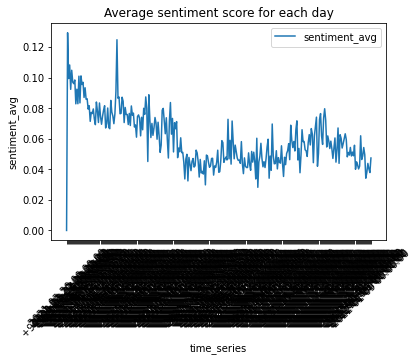

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd



time_series = result_pdf["start"]
sentiment_avg = result_pdf["avg"]

plt.plot(time_series, sentiment_avg, label="sentiment_avg")
plt.title("Average sentiment score for each day")
plt.xlabel("time_series")
plt.ylabel("sentiment_avg")
plt.legend()
plt.xticks(rotation=45)

plt.show()

## Average sentiment score for each country

In [ ]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

result_pdf= df.groupBy("state").avg("sentiment_score").select("*").toPandas()

result_pdf.to_csv('/content/drive/My Drive/big_data/results/avg_score_each_country.csv')  

In [ ]:
result_pdf.head()

,state,avg(sentiment_score)
0,SC,0.056361
1,AZ,0.051603
2,Queens,0.164896
3,LA,0.066239
4,Paradise,0.113112


##  sentiment score for positive/negative/natural label by day(avg)

In [ ]:

from pyspark.sql.window import Window
import datetime

# Positive label
w = df.where(df.sentiment_label=='positive').groupBy(window("timestamp", "1 day")).agg(avg("sentiment_score").alias("avg"))

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
result_pdf=w.select(w.window.start.cast("string").alias("start"), w.window.end.cast("string").alias("end"), "avg").select("*").toPandas()


#result_pdf["start"]=result_pdf["start"].apply(lambda s: datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S'))

result_pdf=result_pdf.sort_values(by="start")
result_pdf.to_csv('/content/drive/My Drive/big_data/results/positive_score_by__day.csv')  

In [ ]:
# Positive label
w = df.where(df.sentiment_label=='negative').groupBy(window("timestamp", "1 day")).agg(avg("sentiment_score").alias("avg"))

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
result_pdf=w.select(w.window.start.cast("string").alias("start"), w.window.end.cast("string").alias("end"), "avg").select("*").toPandas()


#result_pdf["start"]=result_pdf["start"].apply(lambda s: datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S'))

result_pdf=result_pdf.sort_values(by="start")
result_pdf.to_csv('/content/drive/My Drive/big_data/results/negative_score_by__day.csv')  

In [ ]:
# Natural label
w = df.where(df.sentiment_label=='natural').groupBy(window("timestamp", "1 day")).agg(avg("sentiment_score").alias("avg"))

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
result_pdf=w.select(w.window.start.cast("string").alias("start"), w.window.end.cast("string").alias("end"), "avg").select("*").toPandas()


#result_pdf["start"]=result_pdf["start"].apply(lambda s: datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S'))

result_pdf=result_pdf.sort_values(by="start")
result_pdf.to_csv('/content/drive/My Drive/big_data/results/natural_score_by__day.csv')  

In [ ]:
result_pdf.head()

,start,end,avg


##  Count of tweets in each country

In [ ]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
result_pdf= df.groupBy("state").count().select("*").toPandas()
result_pdf.to_csv('/content/drive/My Drive/big_data/results/count_of_country.csv')  

In [ ]:
result_pdf.head()

,state,count
0,SC,4746
1,AZ,14682
2,Queens,25
3,LA,8010
4,Paradise,13


##  Count of tweets by day(avg)

In [ ]:
# Natural label
w = df.groupBy(window("timestamp", "1 day")).count().alias("count")

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
result_pdf=w.select(w.window.start.cast("string").alias("start"), w.window.end.cast("string").alias("end"), "count").select("*").toPandas()


#result_pdf["start"]=result_pdf["start"].apply(lambda s: datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S'))

result_pdf=result_pdf.sort_values(by="start")
result_pdf.to_csv('/content/drive/My Drive/big_data/results/count_of_day.csv')  

In [ ]:
result_pdf.head()

,start,end,count
196,+94603-01-01 00:00:00,+94603-01-02 00:00:00,1
200,2021-03-20 00:00:00,2021-03-21 00:00:00,101
292,2021-03-21 00:00:00,2021-03-22 00:00:00,2334
296,2021-03-22 00:00:00,2021-03-23 00:00:00,3247
198,2021-03-23 00:00:00,2021-03-24 00:00:00,3266


##  Count of likes for psitive/negative tweets

In [ ]:
# Positive likes
result_pdf= df.where(df.sentiment_label=='positive').agg(sum("like_count").alias("sum")).select("*").toPandas()
result_pdf.to_csv('/content/drive/My Drive/big_data/count_likes_positive.csv')  

In [ ]:
# Nositive likes
result_pdf= df.where(df.sentiment_label=='negative').agg(sum("like_count").alias("sum")).select("*").toPandas()
result_pdf.to_csv('/content/drive/My Drive/big_data/count_likes_negative.csv')  

In [ ]:
result_pdf.head()

,sum
0,1837329.0


##  Average sentiment score for Moderna or Pfizer

In [ ]:
def moderna_pfizer(text):
  if "pfizer" in text:
    return "pfizer"
  else:
    return "moderna"

pfizer_moderna_udf = udf(moderna_pfizer , StringType())

df  = df.withColumn("pfizer_moderna", pfizer_moderna_udf( df['tweet'] ))

In [ ]:

from pyspark.sql.window import Window
import datetime

# Pfizer
w = df.where(df.pfizer_moderna=='pfizer').groupBy(window("timestamp", "7 day")).agg(avg("sentiment_score").alias("avg"))

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
result_pdf=w.select(w.window.start.cast("string").alias("start"), w.window.end.cast("string").alias("end"), "avg").select("*").toPandas()


#result_pdf["start"]=result_pdf["start"].apply(lambda s: datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S'))

result_pdf=result_pdf.sort_values(by="start")
result_pdf.to_csv('/content/drive/My Drive/big_data/results/pfizer.csv')  

In [ ]:
# Moderna
w = df.where(df.pfizer_moderna=='moderna').groupBy(window("timestamp", "7 day")).agg(avg("sentiment_score").alias("avg"))

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
result_pdf=w.select(w.window.start.cast("string").alias("start"), w.window.end.cast("string").alias("end"), "avg").select("*").toPandas()


#result_pdf["start"]=result_pdf["start"].apply(lambda s: datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S'))

result_pdf=result_pdf.sort_values(by="start")
result_pdf.to_csv('/content/drive/My Drive/big_data/results/moderna.csv')  

In [ ]:
result_pdf.head()

,start,end,avg
29,+94602-12-30 00:00:00,+94603-01-06 00:00:00,0.000000
30,2021-03-18 00:00:00,2021-03-25 00:00:00,0.100644
40,2021-03-25 00:00:00,2021-04-01 00:00:00,0.090206
33,2021-04-01 00:00:00,2021-04-08 00:00:00,0.090157
27,2021-04-08 00:00:00,2021-04-15 00:00:00,0.078386


## How many users for all the twitts

In [ ]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
result_pdf= df.groupBy("author id").count().select("*").toPandas()
result_pdf.to_csv('/content/drive/My Drive/big_data/results/count_for_users.csv')  

result_pdf.head()

,author id,count
0,22080908.0,129
1,580549931.0,1
2,1470980671.0,3
3,155078285.0,1
4,7.13e+17,173


## Top users - how many twitts and the average sementic score

In [ ]:
# Positive likes
result_pdf= df.groupBy("author id").agg(avg("sentiment_score").alias("avg")).select("*").toPandas()
result_pdf.to_csv('/content/drive/My Drive/big_data/top_users_semantic_score.csv')  

result_pdf.head()

,author id,avg
0,22080908.0,0.103003
1,580549931.0,0.000000
2,1470980671.0,0.027083
3,155078285.0,0.418182
4,7.13e+17,0.077136
